In [5]:
from time import time
import casadi as ca
import numpy as np
from casadi import sin, cos, pi

import matplotlib.pyplot as plt
from simulation_code import simulate

In [6]:
#define the states
x1 = ca.SX.sym('x1')
x2 = ca.SX.sym('x2')
x = ca.vertcat(x1, x2)

#define th controls
u = ca.SX.sym('u')

# Van der Pol oscillator system (nonlinear ODE)
ode = ca.vertcat((1-x2**2)*x1 - x2 + u, x1)

# ODE right-hand side function
f = ca.Function('f', [x, u], [ode], ['x', 'u'], ['ode'])

T = 10
N = 100
sim_time = 20
step_horizon = T/N

# this integration options will integrate for 0.1 seconds
intg_options = {"tf": T/N, 'simplify': True, 'number_of_finite_elements': 4}

#check if f is working by giving f(x, u) and t = 0
# print(f(ca.vertcat(0.2, 0.3), 0.4))
dae = {'x': x, 'ode': ode, 'p': u}
# here p is parameters or stuffs that don't change during integration
#this intg object is a discretized version of the ode
intg = ca.integrator('intg', 'rk', dae, intg_options)

res = intg(x0=x,p=u)
x_next = res['xf']

n_states = x.numel()
n_controls = u.numel()

CasADi - 2023-09-24 02:13:47 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:515]


In [7]:
# given (x,u) compute x_next using F API
F = ca.Function('F', [x, u], [x_next], ['x', 'u'], ['x_next'])
P = ca.SX.sym('P', n_states + n_states)
X = ca.SX.sym('X', n_states, (N+1))
U = ca.SX.sym('U', n_controls, N)

In [8]:
X[:,0] = P[:n_states]
for k in range(N):
    st = X[:,k]
    con = U[:,k]
    f_value = F(st, con)
    st_next = f_value
    X[:,k+1] = st_next

#symbolic expression for optimal trajectory given the current(initialization) state and the control input
ff = ca.Function('ff', [U, P], [X], ['U', 'P'], ['X'])

ff

Function(ff:(U[1x100],P[4])->(X[2x101]) SXFunction)

In [9]:
Q = np.diag([1, 1])
R = np.diag([0.1])

#compute the objective symbolically
obj = 0
for k in range(N):
    st = X[:,k]
    con = U[:,k]
    obj = obj + ca.mtimes([(st-P[n_states:]).T, Q, (st-P[n_states:])]) + ca.mtimes([con.T, R, con])
    

In [10]:
opt_variables = U.reshape((n_controls*N,1))

In [11]:
def shift_timestep(step_horizon, t0, state_init, u, f):
    f_value = f(state_init, u[:, 0])
    next_state = ca.DM.full(state_init + (step_horizon * f_value))

    t0 = t0 + step_horizon
    u0 = ca.horzcat(
        u[:, 1:],
        ca.reshape(u[:, -1], -1, 1)
    )

    return t0, next_state, u0


def DM2Arr(dm):
    return np.array(dm.full())

In [12]:
nlp_prob = {'f': obj, 'x': opt_variables, 'p': P}
opts = {'ipopt': {'max_iter': 100, 'print_level': 5, 'acceptable_tol': 1e-8, 'acceptable_obj_change_tol': 1e-6}, 'print_time': False}

t0 = 0
state_init = ca.DM([0, 1])        # initial state
state_target = ca.DM([0,0])  # target state

xx = ca.DM.zeros((n_states, N+1))
xx[:,0] = state_init
t = ca.DM(t0)

u0 = ca.DM.zeros((n_controls, N))  # initial control
xx1 = np.zeros((n_states, N+1, int(sim_time/step_horizon)))
u_cl = ca.DM.zeros((n_controls, N))  # closed-loop control

print(u0.shape)
mpc_iter = 0
solver = ca.nlpsol('solver', 'ipopt', nlp_prob, opts)
args={}

(1, 100)


In [13]:
main_loop = time()  # return time in sec
times = np.array([[0]])
while (ca.norm_2(state_init - state_target) > 1e-1) and (mpc_iter * step_horizon < sim_time):
    t1 = time()
    args['p'] = ca.vertcat(
        state_init,    # current state
        state_target   # target state
    )
    # optimization variable current state
    args['x0'] = ca.reshape(u0.T, n_controls*(N), 1)
    #print(args['x0'].shape)
    sol = solver(
        x0=args['x0'],
        p=args['p']
    )

    u = ca.reshape(sol['x'].T, n_controls, N)
    ff_value = ff(u.T, args['p'])
    #print(DM2Arr(ff_value).T.shape)
    xx1[:,:N+1,mpc_iter+1] = DM2Arr(ff_value)

    u_cl = ca.horzcat(u[:, 1:], u[:, -1])
    #append the last time step
    t = np.vstack((t,t0))

    t0, state_init, u0 = shift_timestep(step_horizon, t0, state_init, u, f)

    xx[:,mpc_iter+1] = state_init.T

    mpc_iter = mpc_iter + 1
    t2 = time()
    print(mpc_iter)
    print(t2-t1)
    times = np.vstack((times,t2-t1))

main_loop_time = time()
ss_error = ca.norm_2(state_init - state_target)

print('\n\n')
print('Total time: ', main_loop_time - main_loop)
print('avg iteration time: ', np.array(times).mean() * 1000, 'ms')
print('final error: ', ss_error)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     4951

Total number of variables............................:      100
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality c

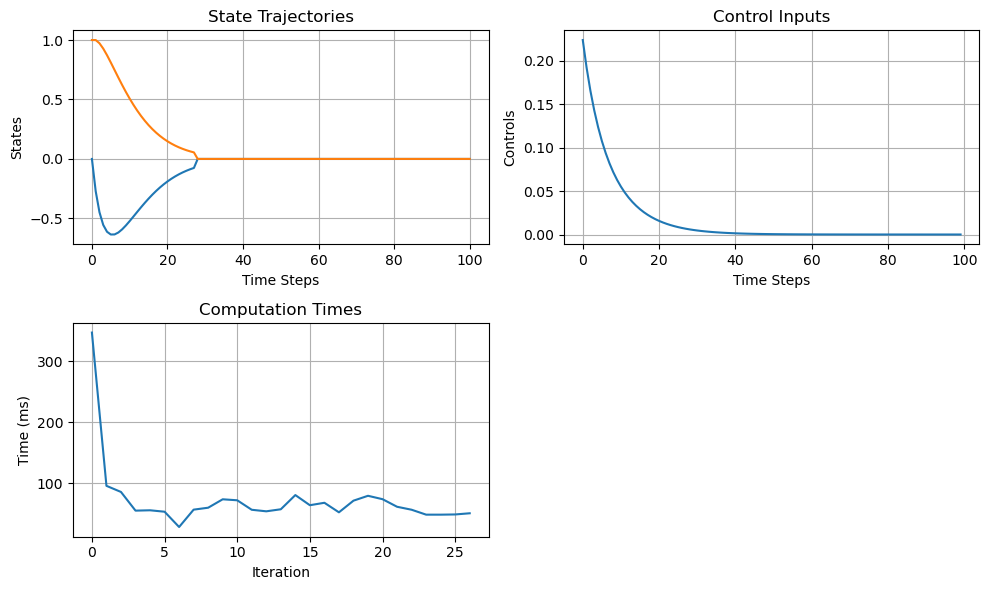

In [14]:
import matplotlib.pyplot as plt
# Plot state trajectories
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.plot(xx.T)
plt.title('State Trajectories')
plt.xlabel('Time Steps')
plt.ylabel('States')
plt.grid(True)

# Plot control inputs
plt.subplot(2, 2, 2)
u_cl_np = np.array(u_cl)  # Convert to numpy array if not already
plt.plot(u_cl_np.T)
plt.title('Control Inputs')
plt.xlabel('Time Steps')
plt.ylabel('Controls')
plt.grid(True)

# Plot computation times
plt.subplot(2, 2, 3)
times_np = np.array(times[1:])  # Convert to numpy array and skip the first element (initialization)
plt.plot(times_np * 1000)  # Convert to milliseconds
plt.title('Computation Times')
plt.xlabel('Iteration')
plt.ylabel('Time (ms)')
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()